In [ ]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback

import time

In [ ]:
x = np.arange(-1,1,0.01)
np.random.shuffle(x)
y = x**2

split_index = int(x.shape[0]*0.6)

train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [ ]:
def train_with_callbacks(callbacks):


  # 모델 정의
  model = keras.Sequential()
  model.add(Dense(10, activation='tanh', input_shape=(1,)))
  model.add(Dense(10, activation='tanh'))
  model.add(Dense(1))


  # 모델 컴파일
  model.compile(optimizer="SGD", loss="mse", metrics=["mse"])
  model.summary()


  # 학습
  start_time = time.time()
  model.fit(train_x, train_y, epochs=200, verbose=0, batch_size=20, validation_split=0.1, callbacks=callbacks)
  print("elapsed : {}".format(time.time() - start_time))


## 로스 출력

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])



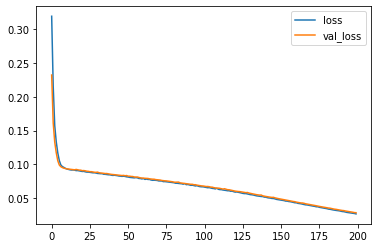

loss =  0.026803738817020698 , val_loss =  0.02860250137746334
elapsed : 36.6471688747406


In [ ]:
plot_losses = PlotLosses()

train_with_callbacks([plot_losses])

## early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=50)         # 중지까지의 여유분

train_with_callbacks([early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
elapsed : 2.4478344917297363


## 학습율 조정

학습 과정을 모니터링 하면서 진척되지 않으면 학습율을 조정한다.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # 모니터링 대상
                              factor=0.2,         # 줄이는 양
                              patience=5,         # 대상 기간동안 유지
                              min_lr=0.001)       # 최소 학습율

train_with_callbacks([reduce_lr])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
elapsed : 2.244915008544922


## 모두 한번에

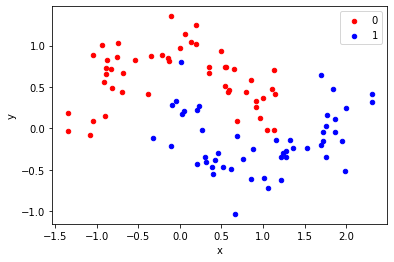

In [ ]:
from sklearn.datasets import make_moons
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from matplotlib import pyplot
from pandas import DataFrame

x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

df = DataFrame(dict(x=x[:,0], y=x[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

split_index = 30
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


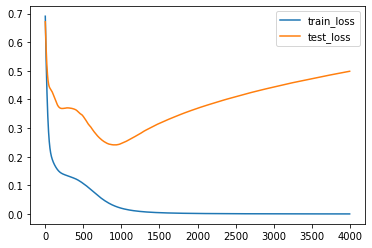

In [ ]:
# copy from https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

model = Sequential()
model.add(Dense(500, input_shape=(2,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=4000, verbose=0)

pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()


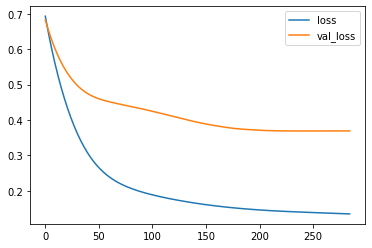

loss =  0.13432855904102325 , val_loss =  0.36912532789366587
Epoch 00285: early stopping


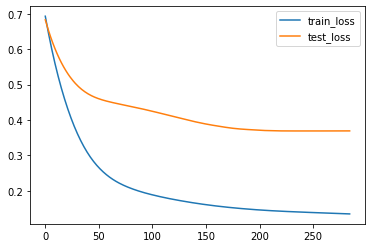

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Dense(500, input_shape=(2,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]


# history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=4000, verbose=0)
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=4000, verbose=0, callbacks=callbacks)


pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()
